In [48]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# Imported Libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

In [49]:
df = pd.read_csv("synthetic_financial_data.csv")
df.head()

,transaction_id,customer_id,merchant_id,amount,transaction_time,is_fraudulent,card_type,location,purchase_category,customer_age,transaction_description
0,1,1082,2027,5758.59,2023-01-01 00:00:00,0,MasterCard,City-30,Gas Station,43,Purchase at Merchant-2027
1,2,1015,2053,1901.56,2023-01-01 00:00:01,1,Visa,City-47,Online Shopping,61,Purchase at Merchant-2053
2,3,1004,2035,1248.86,2023-01-01 00:00:02,1,MasterCard,City-6,Gas Station,57,Purchase at Merchant-2035
3,4,1095,2037,7619.05,2023-01-01 00:00:03,1,Discover,City-6,Travel,59,Purchase at Merchant-2037
4,5,1036,2083,1890.10,2023-01-01 00:00:04,1,MasterCard,City-34,Retail,36,Purchase at Merchant-2083


In [50]:
df['transaction_time'] = pd.to_datetime(df['transaction_time'])  # Mengubah kolom menjadi tipe data datetime64
# Mengubah format waktu
df['transaction_time'] = df['transaction_time'].dt.strftime('%H:%M:%S')
df['transaction_time'] = df['transaction_time'].str.replace(':', '')
df['transaction_time'] = df['transaction_time'].astype("int64")

In [51]:
from sklearn.preprocessing import LabelEncoder

# Membuat objek LabelEncoder
label_encoder = LabelEncoder()

# Menggunakan LabelEncoder untuk mengubah data kategori menjadi angka
df['card_type_transform'] = label_encoder.fit_transform(df['card_type'])
df['location_transform'] = label_encoder.fit_transform(df['location'])
df['purchase_category_transform'] = label_encoder.fit_transform(df['purchase_category'])

In [52]:
df.describe()

,transaction_id,customer_id,merchant_id,amount,transaction_time,is_fraudulent,customer_age,card_type_transform,location_transform,purchase_category_transform
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1051.272300,2050.486600,4958.381617,11992.860000,0.506800,44.047500,1.486900,24.589600,2.501600
std,2886.89568,28.864062,28.877801,2899.699675,7879.853956,0.499979,15.321707,1.116581,14.464193,1.713736
min,1.00000,1001.000000,2001.000000,10.610000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000
25%,2500.75000,1026.000000,2025.000000,2438.175000,4139.750000,0.000000,31.000000,1.000000,12.000000,1.000000
50%,5000.50000,1052.000000,2050.000000,4943.945000,12319.500000,1.000000,44.000000,1.000000,25.000000,2.000000
75%,7500.25000,1076.000000,2076.000000,7499.312500,20469.250000,1.000000,57.000000,2.000000,37.000000,4.000000
max,10000.00000,1100.000000,2100.000000,9999.750000,24639.000000,1.000000,70.000000,3.000000,49.000000,5.000000


In [53]:
# Good No Null Values!
df.isnull().sum().max()

0

In [54]:
df.columns

Index(['transaction_id', 'customer_id', 'merchant_id', 'amount',
       'transaction_time', 'is_fraudulent', 'card_type', 'location',
       'purchase_category', 'customer_age', 'transaction_description',
       'card_type_transform', 'location_transform',
       'purchase_category_transform'],
      dtype='object')

In [55]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(df['is_fraudulent'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['is_fraudulent'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 49.32 % of the dataset
Frauds 50.68 % of the dataset


Fraudulent Cases: 5068
Valid Transactions: 4932
Proportion of Fraudulent Cases: 0.5068


<AxesSubplot: ylabel=' '>

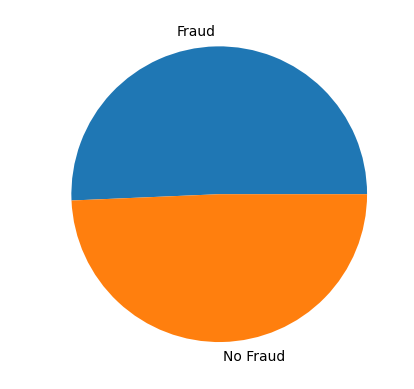

In [56]:
# check for relative proportion 
print("Fraudulent Cases: " + str(len(df[df["is_fraudulent"] == 1])))
print("Valid Transactions: " + str(len(df[df["is_fraudulent"] == 0])))
print("Proportion of Fraudulent Cases: " + str(len(df[df["is_fraudulent"] == 1])/ df.shape[0]))

# To see how small are the number of Fraud transactions
data_p = df.copy()
data_p[" "] = np.where(data_p["is_fraudulent"] == 1 ,  "Fraud", "No Fraud")

# plot a pie chart
data_p[" "].value_counts().plot(kind="pie")

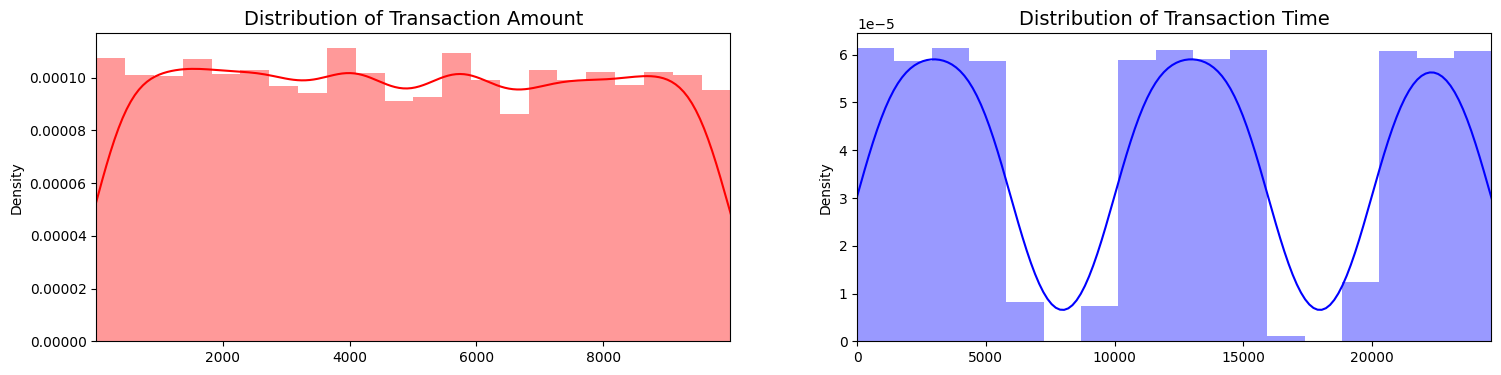

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['amount'].values
time_val = df['transaction_time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()

In [58]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['amount'].values.reshape(-1,1))
df['scaled_transaction_time'] = rob_scaler.fit_transform(df['transaction_time'].values.reshape(-1,1))
df['scaled_customer_age'] = rob_scaler.fit_transform(df['customer_age'].values.reshape(-1,1))
df['scaled_card_type'] = rob_scaler.fit_transform(df['card_type_transform'].values.reshape(-1,1))
df['scaled_location'] = rob_scaler.fit_transform(df['location_transform'].values.reshape(-1,1))
df['scaled_purchase_category'] = rob_scaler.fit_transform(df['purchase_category_transform'].values.reshape(-1,1))

df.drop(['transaction_time','amount','customer_age','card_type_transform','location_transform','purchase_category_transform'], axis=1, inplace=True)

In [59]:
df

,transaction_id,customer_id,merchant_id,is_fraudulent,card_type,location,purchase_category,transaction_description,scaled_amount,scaled_transaction_time,scaled_customer_age,scaled_card_type,scaled_location,scaled_purchase_category
0,1,1082,2027,0,MasterCard,City-30,Gas Station,Purchase at Merchant-2027,0.160961,-0.754432,-0.038462,1.0,-0.08,-0.666667
1,2,1015,2053,1,Visa,City-47,Online Shopping,Purchase at Merchant-2053,-0.601127,-0.754371,0.653846,2.0,0.64,0.000000
2,3,1004,2035,1,MasterCard,City-6,Gas Station,Purchase at Merchant-2035,-0.730090,-0.754310,0.500000,1.0,0.84,-0.666667
3,4,1095,2037,1,Discover,City-6,Travel,Purchase at Merchant-2037,0.528558,-0.754248,0.576923,0.0,0.84,1.000000
4,5,1036,2083,1,MasterCard,City-34,Retail,Purchase at Merchant-2083,-0.603391,-0.754187,-0.307692,1.0,0.08,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,1056,2023,1,MasterCard,City-39,Restaurant,Purchase at Merchant-2023,0.788624,0.754187,-0.307692,1.0,0.28,0.333333
9996,9997,1053,2026,0,MasterCard,City-32,Retail,Purchase at Merchant-2026,-0.970887,0.754248,-0.076923,1.0,0.00,0.666667
9997,9998,1041,2034,0,American Express,City-1,Online Shopping,Purchase at Merchant-2034,0.274582,0.754310,-0.307692,-1.0,-1.00,0.000000
9998,9999,1009,2019,1,Visa,City-11,Retail,Purchase at Merchant-2019,-0.416273,0.754371,0.500000,2.0,-0.92,0.666667


In [61]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(df['is_fraudulent'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['is_fraudulent'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop(columns=['transaction_id','customer_id','merchant_id','card_type','location','purchase_category','transaction_description','is_fraudulent'], axis=1)
y = df['is_fraudulent']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 49.32 % of the dataset
Frauds 50.68 % of the dataset
Train: [1932 1933 1937 ... 9997 9998 9999] Test: [   0    1    2 ... 2060 2061 2062]
Train: [   0    1    2 ... 9997 9998 9999] Test: [1932 1933 1937 ... 4004 4006 4008]
Train: [   0    1    2 ... 9997 9998 9999] Test: [3988 3989 3990 ... 6011 6013 6015]
Train: [   0    1    2 ... 9997 9998 9999] Test: [5991 5992 5993 ... 8011 8013 8014]
Train: [   0    1    2 ... 8011 8013 8014] Test: [7987 7989 7990 ... 9997 9998 9999]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.49325 0.50675]
[0.493 0.507]


Text(0.5, 1.0, "Imbalanced Correlation Matrix \n (don't use for reference)")

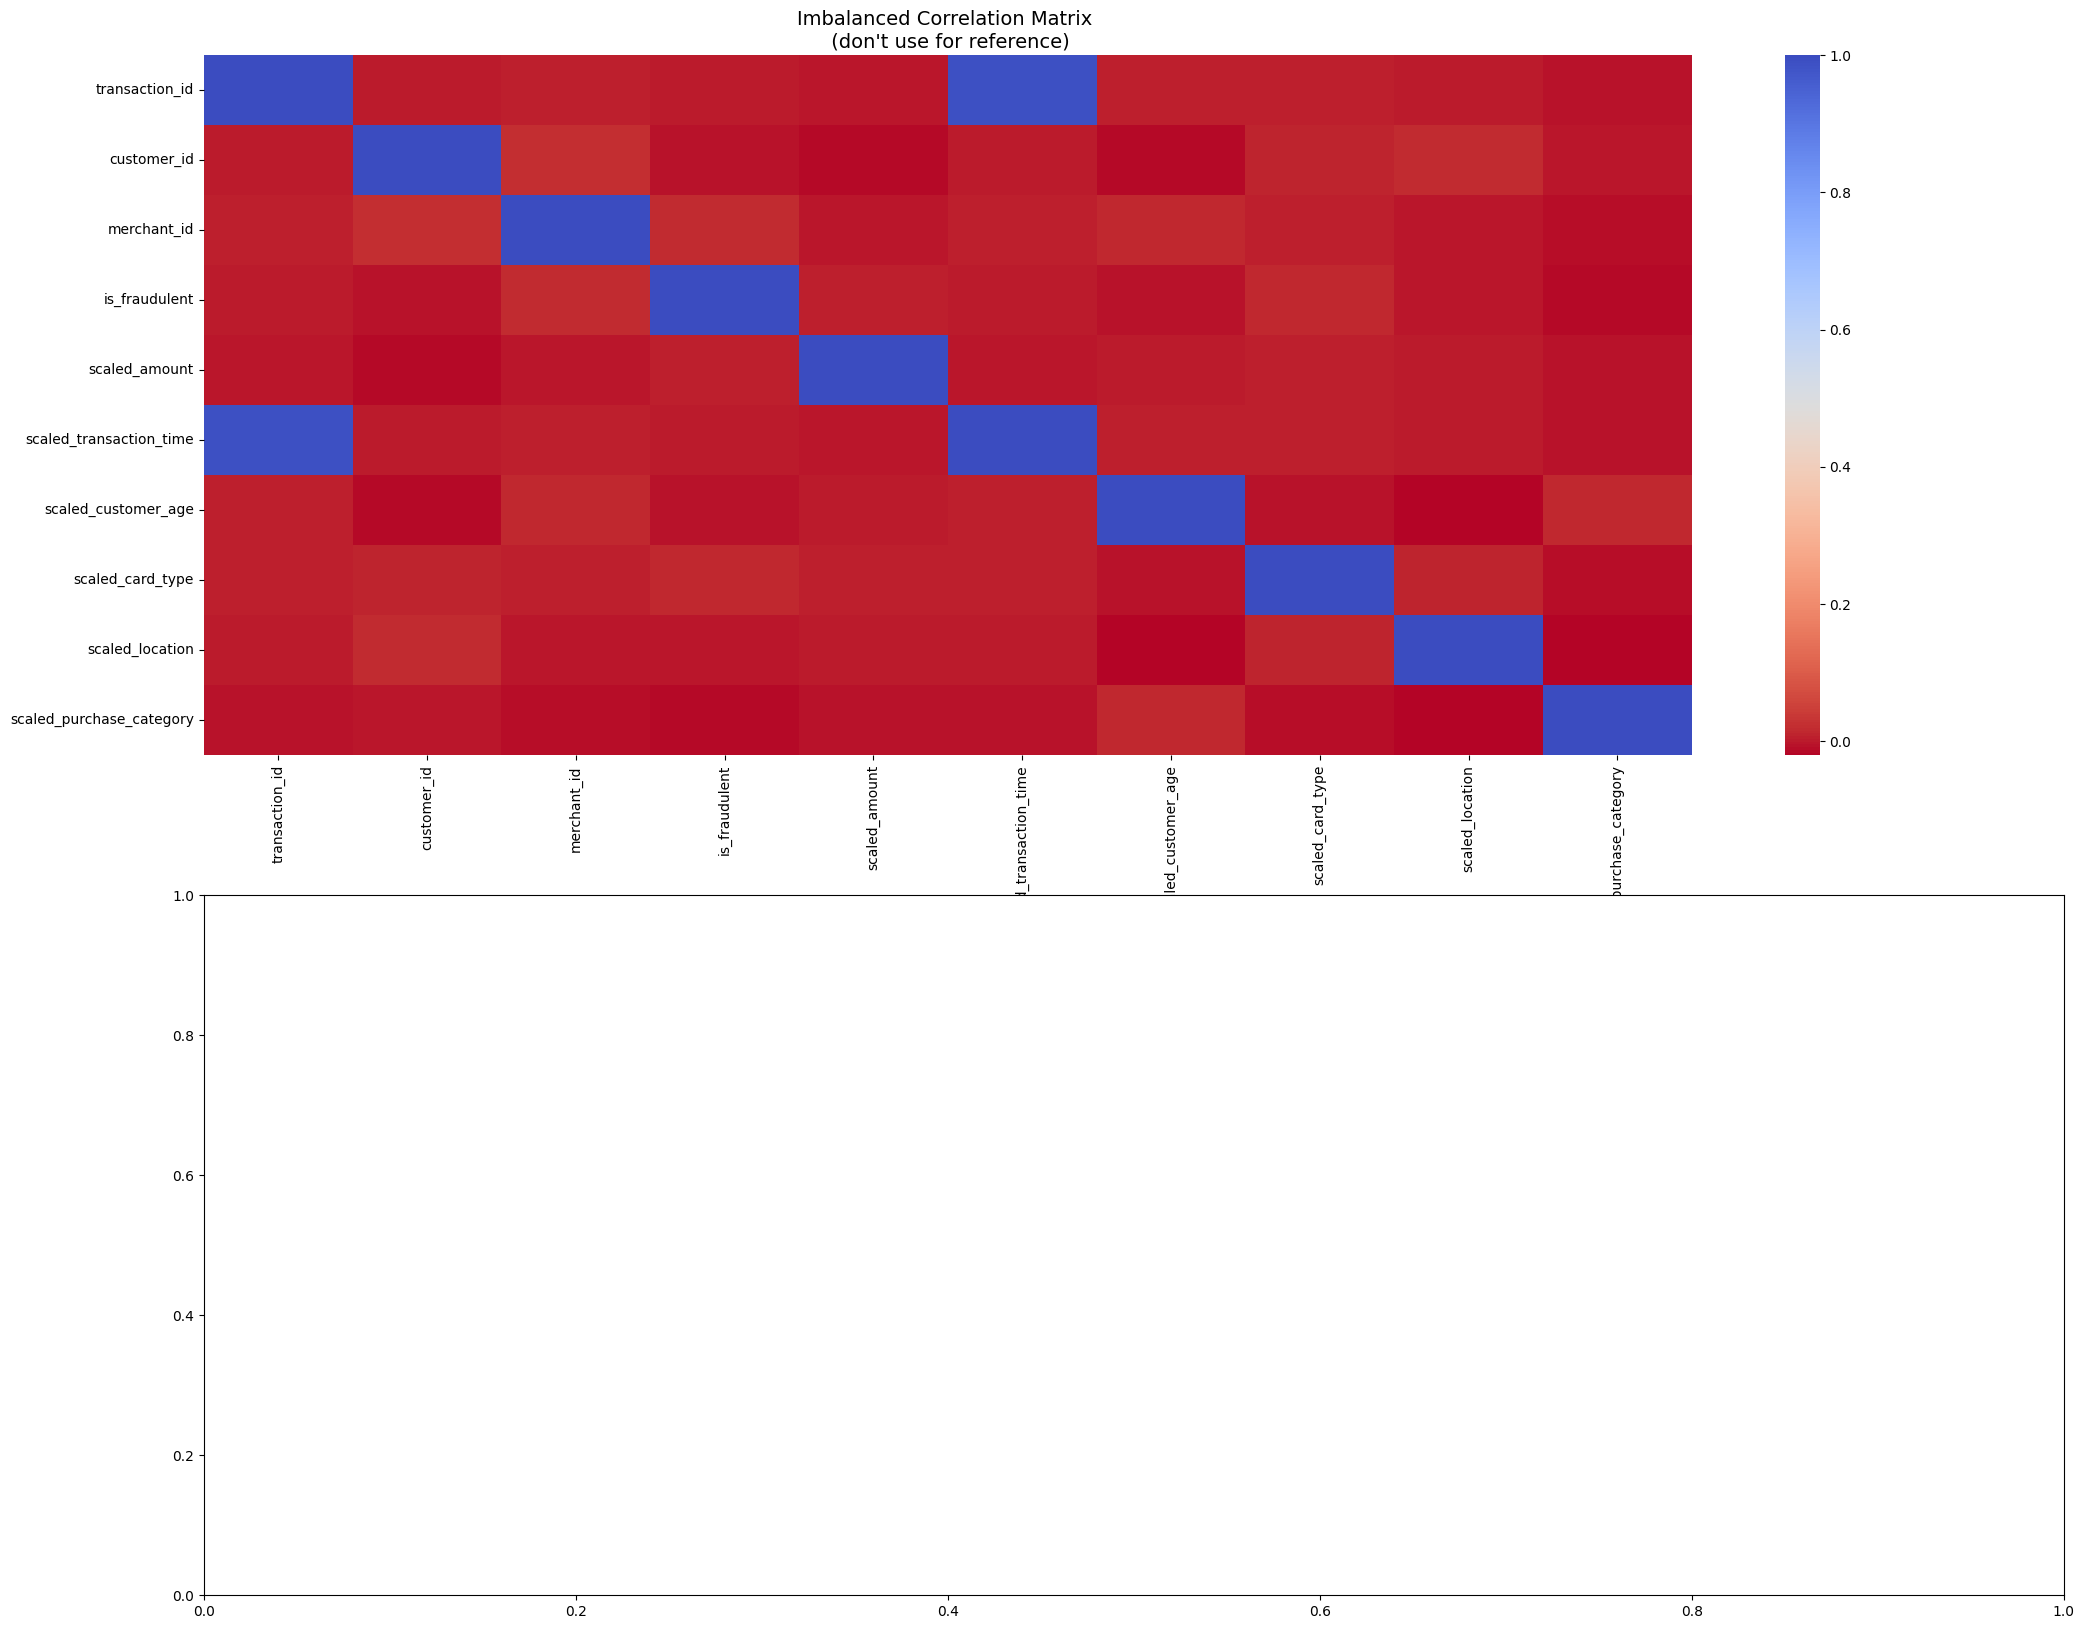

In [63]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)

Text(0.5, 1.0, 'scaled_location Distribution \n (Fraud Transactions)')

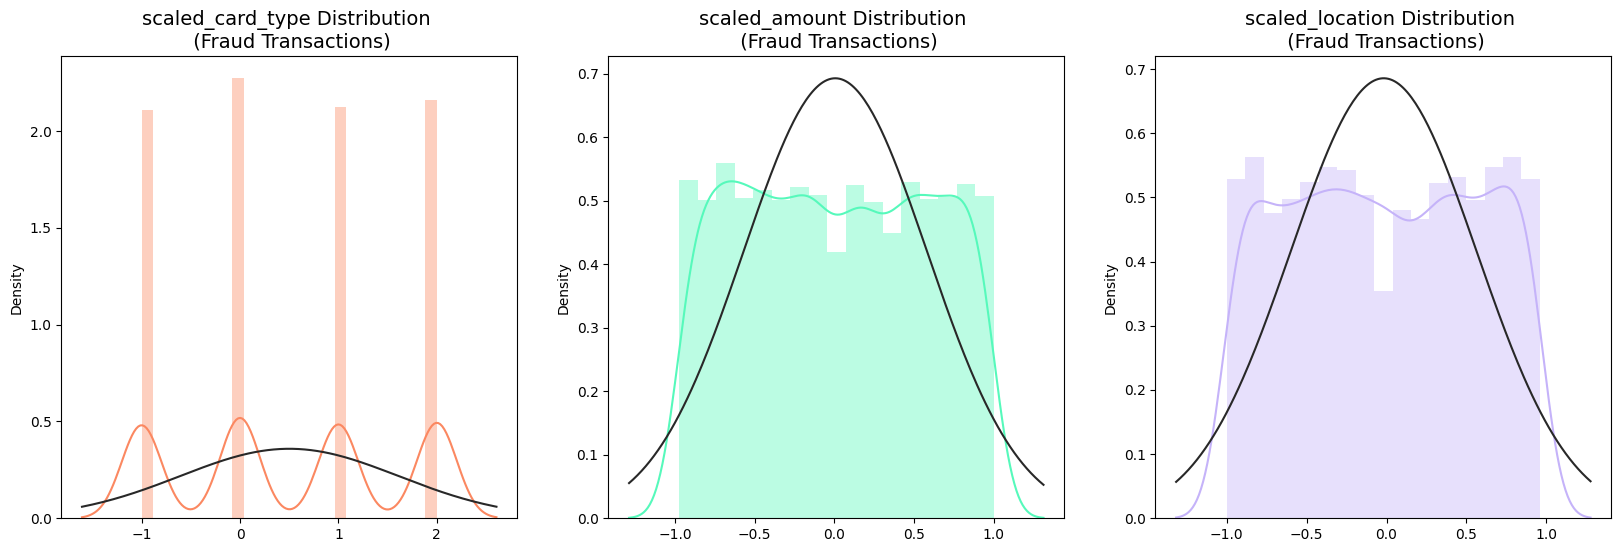

In [64]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = df['scaled_card_type'].loc[df['is_fraudulent'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('scaled_card_type Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = df['scaled_amount'].loc[df['is_fraudulent'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('scaled_amount Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = df['scaled_location'].loc[df['is_fraudulent'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('scaled_location Distribution \n (Fraud Transactions)', fontsize=14)

In [66]:
X = df.drop(columns=['transaction_id','customer_id','merchant_id','card_type','location','purchase_category','transaction_description','is_fraudulent'], axis=1)
y = df['is_fraudulent']

# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# Let's implement simple classifiers

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier()
}

# Wow our scores are getting even high scores even when applying cross validation.
from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 50.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 51.0 % accuracy score
Classifiers:  SVC Has a training score of 50.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 50.0 % accuracy score
Classifiers:  RandomForestClassifier Has a training score of 50.0 % accuracy score


In [67]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV


# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}



grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_

In [68]:
# Overfitting Case

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  49.9%
Knears Neighbors Cross Validation Score 50.92%
Support Vector Classifier Cross Validation Score 50.6%
DecisionTree Classifier Cross Validation Score 50.4%
